In [2]:
from math import *
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple as nt

## Floating point storage

When storing A, B the issue is not that much the number of bits we need for any given curve: we have 64 bits which corresponds to 10^10 which is more than enough to cover all possible prices of a given pair. The problem arises when we want to cover _all possible pair_, especially in a crypto world where prices need to be scaled with 10^ddec where ddec is the difference in decimals between the two tokens. Decimal values can go from 0 to 24, with the core range being from 6 to 18, so this factor can be from 10^12 to 10^24 in the worst case.

In order to store only the scaling factors we need at least 40 bit (18/6) and at worst 80 bit (24/0) case. On top of this we need at least 16 bit for the actual price (10^5), but better 25 bit (10^7). On the face of it this means that we need at least 56-65 bit [which is why we are borderline right now, with 64 bit], but in order to be safe for all edge cases we need 96-115 bit.

However, in reality this is not the case. The reason for this is **that it is not optimal to store the scaling factor as a standard int; instead the exponent should be stored.** As a reminder our scaling factor had to cover 2^0 to 2^80 in the worst case scenario, so 6 bit is a bit tight, but 7 or 8 bit is ample to cover all possible scaling factors and more.


In [15]:
2**64, log10(2**64)

(18446744073709551616, 19.265919722494797)

In [16]:
log2(10**12), log2(10**24), log2(10**5), log2(10**7), log2(80)

(39.86313713864835,
 79.7262742772967,
 16.609640474436812,
 23.253496664211536,
 6.321928094887363)

In [25]:
def scaling_factor_from_store(a, aexp):
    """returns scaling factor based on a and exponent aexp"""
    return a << aexp

In [26]:
scaling_factor_from_store(123456, 12)

505675776

## Separating scaling factor from price

In fact, it is even better to keep the scaling factor and the price value separate, for reasons we are about to explain. Remember that the equation we want to compute trading **by source** is

$$
\Delta x =  \frac{\Delta y\,(Ay+Bz)^2}{\Delta y\, A(Ay+Bz)+z^2} 
$$

Because we can only use int values we use $A = a/s, B = b/s$ where the scaling factor is currently $s=2^{32}$. This yields

$$
\Delta x = \frac 1 {s^2} \cdot \frac{\Delta y\, (ay+bz)^2}{\Delta y\, a(ay+bz)+z^2 s^2} 
$$

For reference, the equation trading **by target** is

$$
\Delta y = \frac{\Delta x\, s^2 z^2}{(ay+bz)(ay+bz+a\Delta x)} 
$$

The art here is now choosing an $s$ such that those equations neither overflow (at 256 bit) because the numbers are too big, nor lose precision because the numbers are too small. Currently we are choosing a single $s$ that is meant to match all possible situations, which is hard. However, most of the parameters either don't change at all ($A,B$) or very rarely, and only in a predictable and limited manner ($z$, when the curve is expanded) or are at least bounded ($y, \Delta x, \Delta y$). Therefore **it should be possible to provide and optimised value of $s$ for a specific curve that performs significantly better than a single value of $s$ that is meant to perform across all curves.**

One thing we need to consider is that -- given the scaling factor is the baseline -- we want to be able go both ways, bigger or smaller. As a reminder: the purpose is to represent `sqrt(B)*s` where $s=2^k$ and B can be smaller or bigger than unity. Let's assume we allocate 40 bits to our base number. This gives us a range of 10^10, but we can of course extend it. In order to be symmetric about unity we defined our new parameters as follows

$$
B = b_0 \cdot 2^{-k-10}
$$

which can be reverse to 

$$
b_0 = B \cdot 2^{k+10}
$$


In [120]:
2**40, log10(2**40)

(1099511627776, 12.041199826559248)

In [85]:
n_bks = nt("r", "B, b0, k, s")
def b0(B, k):
    """calculates b0 as function of B and the scaling exponent k"""
    b0 = int(B * 2**(k+20))
    return n_bks(B, b0, k, 1<<k)

def B(b0, k):
    """calculates B as function of b0 and scaling exponent k"""
    B = int(b0) * 2**(-k-20)
    return n_bks(B, b0, k, 1<<k)

In [122]:
b0_ = b0(1/9, 0)
B(b0_.b0, b0_.k)

r(B=0.1103515625, b0=113, k=0, s=1)

In [123]:
b0_ = b0(1/9, 10)
B(b0_.b0, b0_.k)

r(B=0.11111068725585938, b0=116508, k=10, s=1024)

In [124]:
b0_ = b0(1/9, 25)
B(b0_.b0, b0_.k)

r(B=0.11111111109494232, b0=3817748707, k=25, s=33554432)

In [125]:
b0_ = b0(1/9, 101)
B(b0_.b0, b0_.k)

r(B=0.1111111111111111, b0=288460936585268185572228898750464, k=101, s=2535301200456458802993406410752)

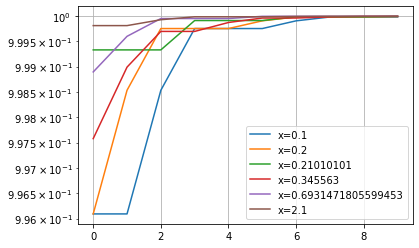

In [118]:
k_r = tuple(range(10))
for x in [0.1, 0.2, 0.21010101, 0.345563, log(2), 2.1]:
    plt.plot(k_r, [B(b0(x, k).b0, k).B/x for k in k_r], label=f"x={x}")
plt.yscale("log")
plt.legend()
plt.grid()